# Lens modeling with lenstronomy
Author: Robin, Anowar Jaman Shajib \
Acknowledgement: Imtiaz, Tanver, Nahid

In [1]:
# make sure lenstronomy is installed, otherwise install the latest pip version
try:
    import lenstronomy
except ModuleNotFoundError:
    !pip install lenstronomy

In [2]:
# import of standard python libraries
import numpy as np
import corner
import matplotlib.pyplot as plt
import h5py
%matplotlib inline

### Extracting the observed image data from a .h5 file

In [24]:
with h5py.File('BDLensing/Data/mock_lens_images_2/team_4_order_2.h5', 'r') as f:
    kwargs_data = {}
    for key in f:
        kwargs_data[key] = f[key][()]
kwargs_data
#exposure_time = kwargs_data['exposure_time']
#exposure_time.shape
#image_data.shape

{'background_rms': 1.0,
 'dec_at_xy_0': -2.5,
 'exposure_time': array([[600., 600., 600., ..., 600., 600., 600.],
        [600., 600., 600., ..., 600., 600., 600.],
        [600., 600., 600., ..., 600., 600., 600.],
        ...,
        [600., 600., 600., ..., 600., 600., 600.],
        [600., 600., 600., ..., 600., 600., 600.],
        [600., 600., 600., ..., 600., 600., 600.]]),
 'image_data': array([[-0.70910201, -0.81254119, -0.12875997, ..., -0.2144622 ,
          0.31570076,  1.2409869 ],
        [ 0.53996501,  1.43192182,  1.799158  , ...,  0.83324296,
          0.113647  ,  2.28778188],
        [ 0.23506993, -0.28914841, -1.74826825, ..., -0.50984343,
         -0.5168777 ,  0.94696373],
        ...,
        [-0.18789608, -0.18832087, -0.75020353, ..., -1.00762068,
          0.22935409,  0.7005064 ],
        [-2.55758573, -0.80295986, -0.93533231, ..., -0.41363519,
         -1.90728174,  1.32390305],
        [-0.47209258,  0.49611125,  0.63811129, ...,  0.22723609,
         -0.3

### Extracting the information about Point Spread Function(PSF) from a .h5 file

In [5]:
with h5py.File('BDLensing/Data/mock_lens_images_2/psf.h5', 'r') as f:
    kwargs_psf = {}
    for key in f:
        kwargs_psf[key] = f[key][()]
kwargs_psf['psf_type'] = 'PIXEL'

/tmp/ipykernel_20778/1783241416.py:2: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(image_data), origin='lower', cmap='cubehelix');


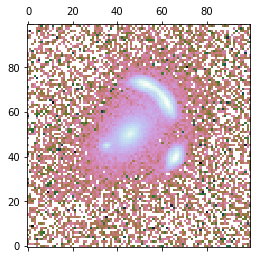

In [17]:
image_data = kwargs_data['image_data']
plt.matshow(np.log10(image_data), origin='lower', cmap='cubehelix');

### Building a lens model

## Building a lens model

Here, we build a lens model. The lens model can be thought of three
components: the lens galaxy's mass model, the lens galaxy's light model, and
the source galaxy's light model. We have to give a list of profiles for each
 component as shown in the next codecell.

The `'EPL'` lens mass profile stands for Elliptical Power Law. The form of
this convergence profile is given by:
$$\kappa(x, y) = \frac{3 - \gamma}{2} \left[ \frac{\theta_{\rm E}}{\sqrt{q
x^2 + y^2 / q}} \right]^{\gamma - 1}. $$

The position angle $\phi$ adjusts the orientation of the mass profile's
major axis. The ellipticity parameters $q$ and $\phi$ can be reformulated as
$$e_1 = \frac{1 - q}{1 + q} \cos 2\phi,$$
$$e_2 = \frac{1 - q}{1 + q} \sin 2\phi.$$

`lenstronomy` uses $e_1$ and $e_2$ instead of $q$ and $\phi$, because $e_1$
and $e_2$ are easier to handle in numerical optimization, for example, in
MCMC. You can check [here](https://github.com/lenstronomy/lenstronomy-tutorials/blob/main/Notebooks/GettingStarted/units_coordinates_parameters_definitions.ipynb) for more details on
parameter definitions and conventions used in `lenstronomy`.


Both the lens galaxy's and the source galaxy's light profiles are modeled
with Sersic function, which is given by:

$$I(x, y) = I_{\rm e} \exp \left[ -b_{n} \left\{ \left( \frac{\sqrt{q x^2
+ y^2/q}}{R_{\rm Sersic}} \right)^{1/n_{\rm Sersic}} - 1 \right\}
\right].$$

In [6]:
lens_model_list = ['EPL', 'SHEAR']
source_model_list = ['SERSIC_ELLIPSE', 'SHAPELETS']
lens_light_model_list = ['SERSIC_ELLIPSE']

In this cell below, we have to specify the initial values, upper and lower
limits for the model parameters specific to each of the model components
specified in the above lists. The `kwargs_*_sigma` dictionaries/lists are
used to set the initial size of the search area within particle swarm
optimization (PSO) or MCMC.

### Mass model of the lens galaxy

In [7]:
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

# EPL Profile
fixed_lens.append({})
kwargs_lens_init.append({'theta_E': 1., 'gamma': 2.,
                         'e1': 0., 'e2': 0.,
                         'center_x': 0., 'center_y': 0.})
kwargs_lens_sigma.append({'theta_E': .2, 'gamma': .1,
                          'e1': 0.05, 'e2': 0.05,
                          'center_x': 0.5, 'center_y': 0.5})
kwargs_lower_lens.append({'theta_E': 0.01, 'gamma': 1.,
                          'e1': -0.5, 'e2': -0.5,
                          'center_x': -10, 'center_y': -10})
kwargs_upper_lens.append({'theta_E': 10., 'gamma': 3.,
                          'e1': 0.5, 'e2': 0.5,
                          'center_x': 10, 'center_y': 10})
# SHEAR Profile
fixed_lens.append({'ra_0': 0., 'dec_0': 0.})
kwargs_lens_init.append({'gamma1': 0., 'gamma2': 0.,
                         'ra_0': 0., 'dec_0': 0.})
kwargs_lens_sigma.append({'gamma1': 0.05, 'gamma2': 0.05,
                          'ra_0': 0.5, 'dec_0': 0.5})
kwargs_lower_lens.append({'gamma1': -0.3, 'gamma2': -0.3,
                          'ra_0': -10, 'dec_0': -10})
kwargs_upper_lens.append({'gamma1': 0.3, 'gamma2': 0.3,
                          'ra_0': 10, 'dec_0': 10})

lens_params = [kwargs_lens_init, kwargs_lens_sigma, fixed_lens,
               kwargs_lower_lens, kwargs_upper_lens]

### Light model of the lens galaxy

In [8]:
fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []

# SERSIC_ELLIPSE Profile
fixed_lens_light.append({'n_sersic': 4.})
kwargs_lens_light_init.append({'R_sersic': 0.5, 'n_sersic': 2.,
                               'e1': 0., 'e2': 0.,
                               'center_x': 0., 'center_y': 0., 'amp': 16})
kwargs_lens_light_sigma.append({'R_sersic': 0.3, 'n_sersic': 1,
                                'e1': 0.05, 'e2': 0.05,
                                'center_x': 0.1, 'center_y': 0.1, 'amp': 10})
kwargs_lower_lens_light.append({'R_sersic': .001, 'n_sersic': 0.5,
                                'e1': -0.5, 'e2': -0.5,
                                'center_x': -10, 'center_y': -10, 'amp': 0})
kwargs_upper_lens_light.append({'R_sersic': 10, 'n_sersic': 5.,
                                'e1': 0.5, 'e2': 0.5,
                                'center_x': 10, 'center_y': 10, 'amp': 100})

joint_lens_with_light = [[0, 0, ['center_x', 'center_y', 'e1', 'e2']]]
lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma,
                     fixed_lens_light, kwargs_lower_lens_light,
                     kwargs_upper_lens_light]

### Light model of the source galaxy

In [9]:
fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []

# SERSIC_ELLIPSE profile
fixed_source.append({'n_sersic': 1.})
kwargs_source_init.append({'R_sersic': 0.2, 'n_sersic': 1.,
                           'e1': 0., 'e2': 0.,
                           'center_x': 0., 'center_y': 0., 'amp': 16})
kwargs_source_sigma.append({'R_sersic': 0.1, 'n_sersic': 0.5,
                            'e1': 0.1, 'e2': 0.1,
                            'center_x': 0.2, 'center_y': 0.2, 'amp': 10})
kwargs_lower_source.append({'R_sersic': 0.001, 'n_sersic': 0.5,
                            'e1': -0.5, 'e2': -0.5,
                            'center_x': -10, 'center_y': -10, 'amp': 0})
kwargs_upper_source.append({'R_sersic': 10, 'n_sersic': 5.,
                            'e1': 0.5, 'e2': 0.5,
                            'center_x': 10, 'center_y': 10, 'amp': 100})

# SHAPELETS profile
fixed_source.append({'n_max': 6})
kwargs_source_init.append({'beta': 0.1, 'n_max': 6,
                           'center_x': 0., 'center_y': 0.})
kwargs_source_sigma.append({'beta': 0.1, 'n_max': 1,
                            'center_x': 0.2, 'center_y': 0.2})
kwargs_lower_source.append({'beta': 0.01, 'n_max': 4,
                            'center_x': -10, 'center_y': -10})
kwargs_upper_source.append({'beta': 10, 'n_max': 6,
                            'center_x': 10, 'center_y': 10})

joint_source_with_source = [[0, 1, ['center_x', 'center_y']]]
source_params = [kwargs_source_init, kwargs_source_sigma, fixed_source,
                 kwargs_lower_source, kwargs_upper_source]

In [10]:
# Combining all the above specification in the `kwargs_params` dictionary
kwargs_params = {'lens_model': lens_params,
                 'source_model': source_params,
                 'lens_light_model': lens_light_params}

kwargs_constraints = {'joint_lens_with_light': joint_lens_with_light,
                      'joint_source_with_source': joint_source_with_source}

#### Numerical settings

In [11]:
kwargs_likelihood = {'check_bounds': True}

kwargs_numerics = {'supersampling_factor': 1,
                   'supersampling_convolution': False
                   }

#### Combining all the information to be sent to lenstronomy

In [12]:
kwargs_model = {'lens_model_list': lens_model_list,
                'source_light_model_list': source_model_list,
                'lens_light_model_list': lens_light_model_list}

multi_band_list = [[kwargs_data, kwargs_psf, kwargs_numerics]]

kwargs_data_joint = {'multi_band_list': multi_band_list,
                     'multi_band_type': 'single-band'
                     }

## Here the model fiting is done

In [25]:
from lenstronomy.Workflow.fitting_sequence import FittingSequence

fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model,
                              kwargs_constraints, kwargs_likelihood,
                              kwargs_params)

fitting_kwargs_list = [['PSO', {'sigma_scale': 1., 'n_particles': 50,
                                'n_iterations': 50}]
                       ]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

Computing the PSO ...
10
20
30
40
50
Max iteration reached! Stopping.
-3.9279711170835343 reduced X^2 of best position
-19551.47623528329 log likelihood
9955 effective number of data points
[{'theta_E': 0.9435840878074794, 'gamma': 1.8610899242793104, 'e1': 0.005825845519162381, 'e2': -0.039939810832350583, 'center_x': 0.18736851348129493, 'center_y': 0.05493277535890064}, {'gamma1': -0.08697973695260487, 'gamma2': 0.0875101059157489, 'ra_0': 0.0, 'dec_0': 0.0}] lens result
[{'amp': 1, 'R_sersic': 0.0808358122665189, 'n_sersic': 1.0, 'e1': -0.04854279112293994, 'e2': 0.24191950670641238, 'center_x': 0.021372599414247608, 'center_y': 0.09678118907886152}, {'amp': 1, 'n_max': 6, 'beta': 0.010863676277463262, 'center_x': 0.021372599414247608, 'center_y': 0.09678118907886152}] source result
[{'amp': 1, 'R_sersic': 1.04006287713334, 'n_sersic': 4.0, 'e1': 0.005825845519162381, 'e2': -0.039939810832350583, 'center_x': 0.18736851348129493, 'center_y': 0.05493277535890064}] lens light result
[

## Visualizing the fitted model

-3.9102952470566583 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  3.9102952470566574


/home/robin/.local/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:148: RuntimeWarning: invalid value encountered in log10
  np.log10(self._data),
/tmp/ipykernel_20778/2651988041.py:16: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


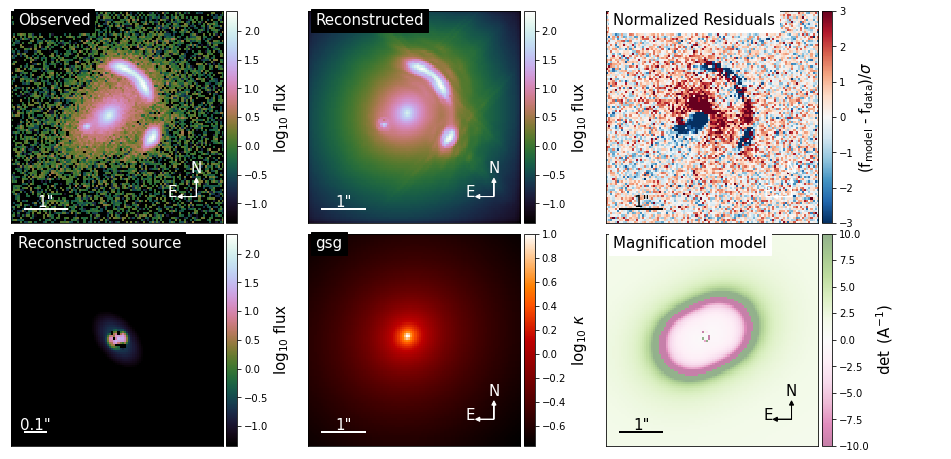

/home/robin/.local/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:1062: RuntimeWarning: invalid value encountered in log10
  np.log10(model),


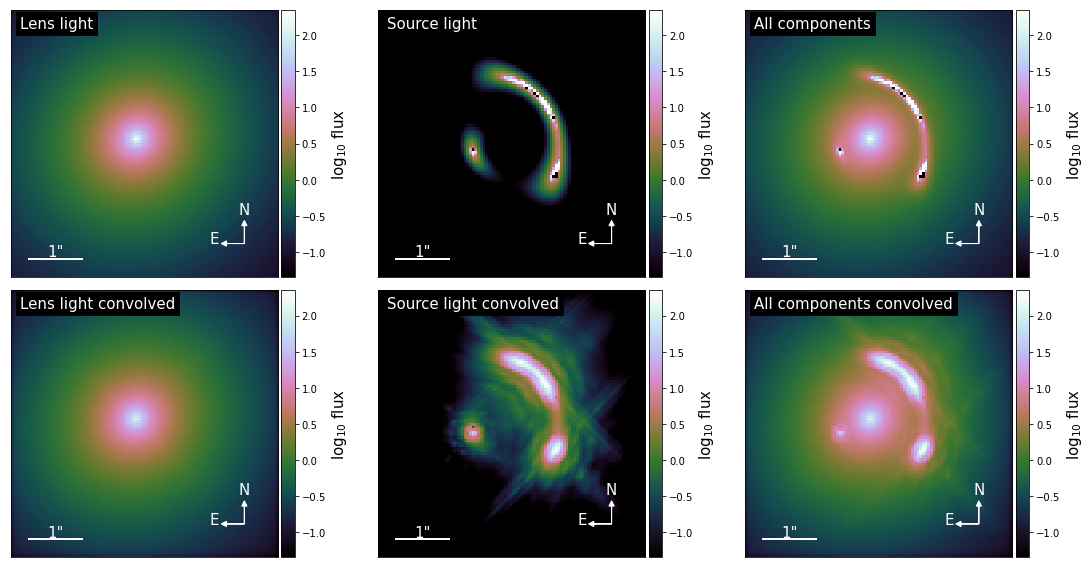

{'kwargs_lens': [{'theta_E': 0.9435840878074794, 'gamma': 1.8610899242793104, 'e1': 0.005825845519162381, 'e2': -0.039939810832350583, 'center_x': 0.18736851348129493, 'center_y': 0.05493277535890064}, {'gamma1': -0.08697973695260487, 'gamma2': 0.0875101059157489, 'ra_0': 0.0, 'dec_0': 0.0}], 'kwargs_source': [{'amp': 1078.452096548512, 'R_sersic': 0.0808358122665189, 'n_sersic': 1.0, 'e1': -0.04854279112293994, 'e2': 0.24191950670641238, 'center_x': 0.021372599414247608, 'center_y': 0.09678118907886152}, {'amp': array([ 552408.63048123, -121228.77067525,   29563.46270063,
        244004.38861024, -201703.21027147,   45339.73247556,
        -84389.12446691,   39548.8977857 ,   87367.23588201,
         84956.44725906,  218287.31466575,  -34517.36496286,
         16972.74661826,   40116.32929386,  -75584.34509196,
        -15671.4619603 ,  118080.45088643,  -42735.4792473 ,
         47058.88030996,   37030.94090618,  -26100.23788284,
        159897.11900974,  -14543.21304048,    3986.513

In [26]:
from lenstronomy.Plots.model_plot import ModelPlot

modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result,
                      arrow_size=0.02, cmap_string="cubehelix",
                      )

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.data_plot(ax=axes[0, 0])
modelPlot.model_plot(ax=axes[0, 1])
modelPlot.normalized_residual_plot(ax=axes[0, 2], v_min=-3, v_max=3,
                                   cmap='RdBu_r')
modelPlot.source_plot(ax=axes[1, 0], deltaPix_source=0.01, numPix=100)
modelPlot.convergence_plot(ax=axes[1, 1], text = 'gsg', v_max=1, cmap='gist_heat')
modelPlot.magnification_plot(ax=axes[1, 2], cmap='PiYG')
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None,
                  top=None, wspace=0., hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.decomposition_plot(ax=axes[0, 0],
                             text='Lens light', lens_light_add=True,
                             unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1, 0],
                             text='Lens light convolved', lens_light_add=True)
modelPlot.decomposition_plot(ax=axes[0, 1],
                             text='Source light', source_add=True,
                             unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1, 1],
                             text='Source light convolved', source_add=True)
modelPlot.decomposition_plot(ax=axes[0, 2],
                             text='All components', source_add=True,
                             lens_light_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1, 2],
                             text='All components convolved', source_add=True,
                             lens_light_add=True, point_source_add=True)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None,
                  top=None, wspace=0., hspace=0.05)
plt.show()
print(kwargs_result)